Mounting with drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Importing important Library


In [3]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import VGG16, ResNet50

Dataset Paths

In [4]:
data_dir = '/content/Dataset-20241004T134004Z-001.zip'

Unziping the data

In [5]:
!unzip /content/Dataset-20241004T134004Z-001.zip
data_dir = '/content/Dataset'

Archive:  /content/Dataset-20241004T134004Z-001.zip
  inflating: Dataset/CML/2316_output_output_output.jpg  
  inflating: Dataset/CML/images (4)_output_output_output.jpg  
  inflating: Dataset/CML/2224_output_output_output.jpg  
  inflating: Dataset/CML/3703_output_output_output.jpg  
  inflating: Dataset/CML/images (2)_output_output_output.jpg  
  inflating: Dataset/CML/60172_output_output_output.jpg  
  inflating: Dataset/CML/images (24)_output_output_output.jpg  
  inflating: Dataset/CML/2825_output_output_output.jpg  
  inflating: Dataset/CML/download (2)_output_output_output.jpg  
  inflating: Dataset/CML/60170_output_output_output.jpg  
  inflating: Dataset/CML/2322_output_output_output.jpg  
  inflating: Dataset/CML/images (1)_output_output_output.jpg  
  inflating: Dataset/CML/3704_output_output_output.jpg  
  inflating: Dataset/CML/2818_output_output_output.jpg  
  inflating: Dataset/CML/62487_output_output_output.jpg  
  inflating: Dataset/CML/1054_output_output_output.jpg  


Data Preprocessing and Augmentation and ImageDataGenerator use here for Training, validation and Testing.

In [6]:
datagen =ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2
)

Loading training and validation data from directory

In [7]:
train_gen = datagen.flow_from_directory(
    data_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

Found 1920 images belonging to 6 classes.


In [8]:
val_gen = datagen.flow_from_directory(
    data_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

Found 480 images belonging to 6 classes.


Test generator without augmentation

In [9]:
test_datagen = ImageDataGenerator(rescale=1./255)
test_gen = test_datagen.flow_from_directory(
    data_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical'
)

Found 2400 images belonging to 6 classes.


Building CNN Model from Scratch

In [10]:
from tensorflow.keras import models, layers
def build_cnn_model():
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(512, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(train_gen.num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

Transfer Learning Model With VGG16

In [11]:
def build_transfer_vgg16():
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
    base_model.trainable = False  # Freeze base model layers
    model = models.Sequential([
        base_model,
        layers.Flatten(),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.5),  # Dropout to prevent overfitting
        layers.Dense(train_gen.num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

Trnsfer Learning with ResNet50, in this section I can choose any model but prefered this model bucause it's close to Transerfer learning Model. I can also choose custom CNN model which is also acceptable.

In [12]:
def build_transfer_resnet50():
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
    base_model.trainable = False
    model = models.Sequential([
        base_model,
        layers.Flatten(),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(train_gen.num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

Traning Models with Early Stopping to Prevent Overfitting.

In [15]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

CNN Model

In [16]:
cnn_model = build_cnn_model()
cnn_history = cnn_model.fit(train_gen, epochs=20, validation_data=val_gen, callbacks=[early_stopping])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


60/60 ━━━━━━━━━━━━━━━━━━━━ 135s 2s/step - accuracy: 0.1731 - loss: 1.8116 - val_accuracy: 0.3625 - val_loss: 1.5090
Epoch 2/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 142s 2s/step - accuracy: 0.3829 - loss: 1.3815 - val_accuracy: 0.4167 - val_loss: 1.1954
Epoch 3/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 131s 2s/step - accuracy: 0.4381 - loss: 1.1618 - val_accuracy: 0.4375 - val_loss: 1.0264
Epoch 4/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 150s 2s/step - accuracy: 0.5265 - loss: 0.9848 - val_accuracy: 0.5146 - val_loss: 0.9159
Epoch 5/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 133s 2s/step - accuracy: 0.5771 - loss: 0.9445 - val_accuracy: 0.6021 - val_loss: 0.7629
Epoch 6/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 143s 2s/step - accuracy: 0.5912 - loss: 0.8677 - val_accuracy: 0.5396 - val_loss: 0.8775
Epoch 7/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 133s 2s/step - accuracy: 0.6072 - loss: 0.9074 - val_accuracy: 0.5938 - val_loss: 0.7649
Epoch 8/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 146s 2s/step - accuracy: 0.6087 - loss: 0.8821 - val_accuracy: 0.5938 - val_loss: 0.

In [17]:
vgg16_model = build_transfer_vgg16()
vgg16_history = vgg16_model.fit(train_gen, epochs=20, validation_data=val_gen, callbacks=[early_stopping])

Epoch 1/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 685s 11s/step - accuracy: 0.3482 - loss: 1.7777 - val_accuracy: 0.5333 - val_loss: 1.0846
Epoch 2/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 687s 11s/step - accuracy: 0.5666 - loss: 1.0643 - val_accuracy: 0.5875 - val_loss: 0.9476
Epoch 3/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 696s 12s/step - accuracy: 0.5811 - loss: 1.0024 - val_accuracy: 0.5979 - val_loss: 0.9024
Epoch 4/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 693s 12s/step - accuracy: 0.6216 - loss: 0.9131 - val_accuracy: 0.6438 - val_loss: 0.8621
Epoch 5/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 681s 11s/step - accuracy: 0.6616 - loss: 0.8204 - val_accuracy: 0.5958 - val_loss: 0.9270


VGG16 Transfer Lerning Model

In [18]:
resnet50_model = build_transfer_resnet50()
resnet50_history = resnet50_model.fit(train_gen, epochs=20, validation_data=val_gen, callbacks=[early_stopping])

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Epoch 1/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 271s 4s/step - accuracy: 0.1915 - loss: 2.8891 - val_accuracy: 0.3458 - val_loss: 1.5383
Epoch 2/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 265s 4s/step - accuracy: 0.2679 - loss: 1.6494 - val_accuracy: 0.3354 - val_loss: 1.4983
Epoch 3/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 351s 5s/step - accuracy: 0.2704 - loss: 1.6139 - val_accuracy: 0.3438 - val_loss: 1.4519
Epoch 4/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 289s 4s/step - accuracy: 0.3025 - loss: 1.5539 - val_accuracy: 0.3187 - val_loss: 1.4701
Epoch 5/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 292s 5s/step - accuracy: 0.2819 - loss: 1.5526 - val_accuracy: 0.3812 - val_loss: 1.4498


ResNet50 Transfer Learning Model

In [32]:
def evaluate_model(model, test_gen):
    test_loss, test_acc = model.evaluate(test_gen)
    print(f"Test Accuracy: {test_acc:.4f}")
    predictions = model.predict(test_gen)
    y_true = test_gen.classes
    y_pred = np.argmax(predictions, axis=1)

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=test_gen.class_indices.keys(), yticklabels=test_gen.class_indices.keys())
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()
    print(classification_report(y_true, y_pred, target_names=test_gen.class_indices.keys()))

Evaluating the CNN model based on the test set.

75/75 ━━━━━━━━━━━━━━━━━━━━ 40s 536ms/step - accuracy: 0.7605 - loss: 0.5170
Test Accuracy: 0.7613
75/75 ━━━━━━━━━━━━━━━━━━━━ 40s 529ms/step


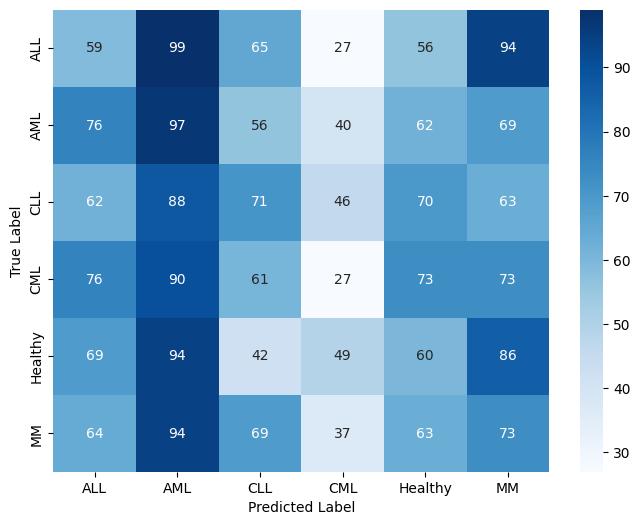

              precision    recall  f1-score   support

         ALL       0.15      0.15      0.15       400
         AML       0.17      0.24      0.20       400
         CLL       0.20      0.18      0.19       400
         CML       0.12      0.07      0.09       400
     Healthy       0.16      0.15      0.15       400
          MM       0.16      0.18      0.17       400

    accuracy                           0.16      2400
   macro avg       0.16      0.16      0.16      2400
weighted avg       0.16      0.16      0.16      2400



In [34]:
!pip install seaborn
import seaborn as sns
evaluate_model(cnn_model, test_gen)

Evaluating the VGG16 Transfer Learning model based on the test set.

75/75 ━━━━━━━━━━━━━━━━━━━━ 724s 10s/step - accuracy: 0.6422 - loss: 0.9840
Test Accuracy: 0.6463
75/75 ━━━━━━━━━━━━━━━━━━━━ 670s 9s/step


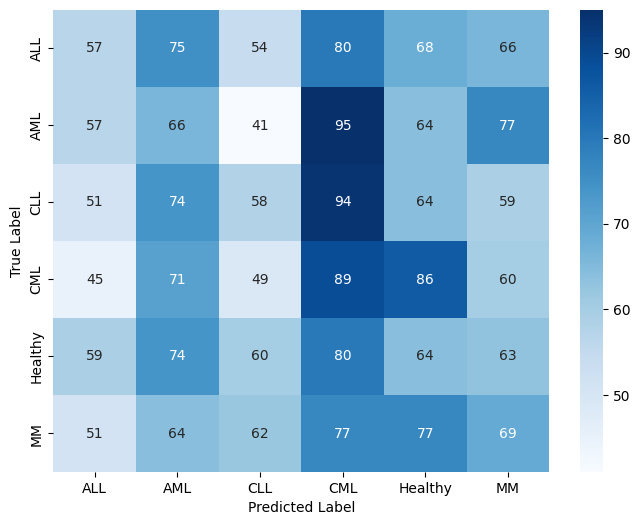

              precision    recall  f1-score   support

         ALL       0.18      0.14      0.16       400
         AML       0.16      0.17      0.16       400
         CLL       0.18      0.14      0.16       400
         CML       0.17      0.22      0.19       400
     Healthy       0.15      0.16      0.16       400
          MM       0.18      0.17      0.17       400

    accuracy                           0.17      2400
   macro avg       0.17      0.17      0.17      2400
weighted avg       0.17      0.17      0.17      2400



In [35]:
evaluate_model(vgg16_model, test_gen)

Evaluating the ResNet50 Transfer Learning model based on the test set.

75/75 ━━━━━━━━━━━━━━━━━━━━ 224s 3s/step - accuracy: 0.2946 - loss: 1.5783
Test Accuracy: 0.3096
75/75 ━━━━━━━━━━━━━━━━━━━━ 224s 3s/step


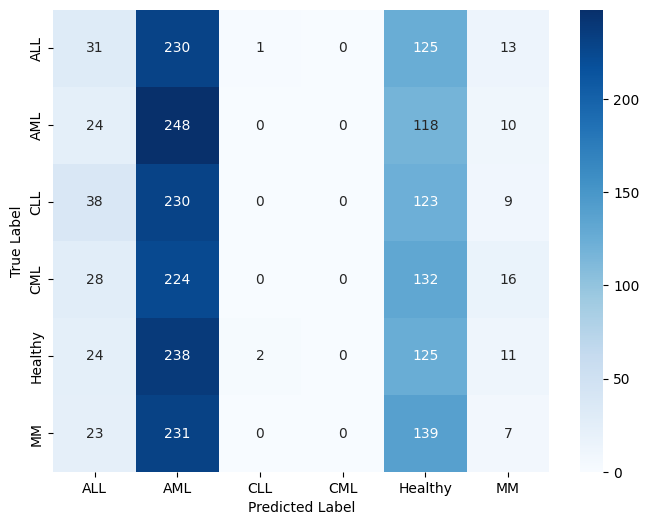

              precision    recall  f1-score   support

         ALL       0.18      0.08      0.11       400
         AML       0.18      0.62      0.28       400
         CLL       0.00      0.00      0.00       400
         CML       0.00      0.00      0.00       400
     Healthy       0.16      0.31      0.22       400
          MM       0.11      0.02      0.03       400

    accuracy                           0.17      2400
   macro avg       0.11      0.17      0.10      2400
weighted avg       0.11      0.17      0.10      2400



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [36]:
evaluate_model(resnet50_model, test_gen)

Visualising the Traing and Validation Accuracy/Loss for compare each of the model.

In [37]:
def plot_training(history, title):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 8))
    plt.plot(epochs, acc, 'b', label='Training accuracy')
    plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
    plt.title(f'Training and Validation Accuracy - {title}')
    plt.legend()
    plt.show()

    plt.figure(figsize=(12, 8))
    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title(f'Training and Validation Loss - {title}')
    plt.legend()
    plt.show()

Ploting all the data for each models.

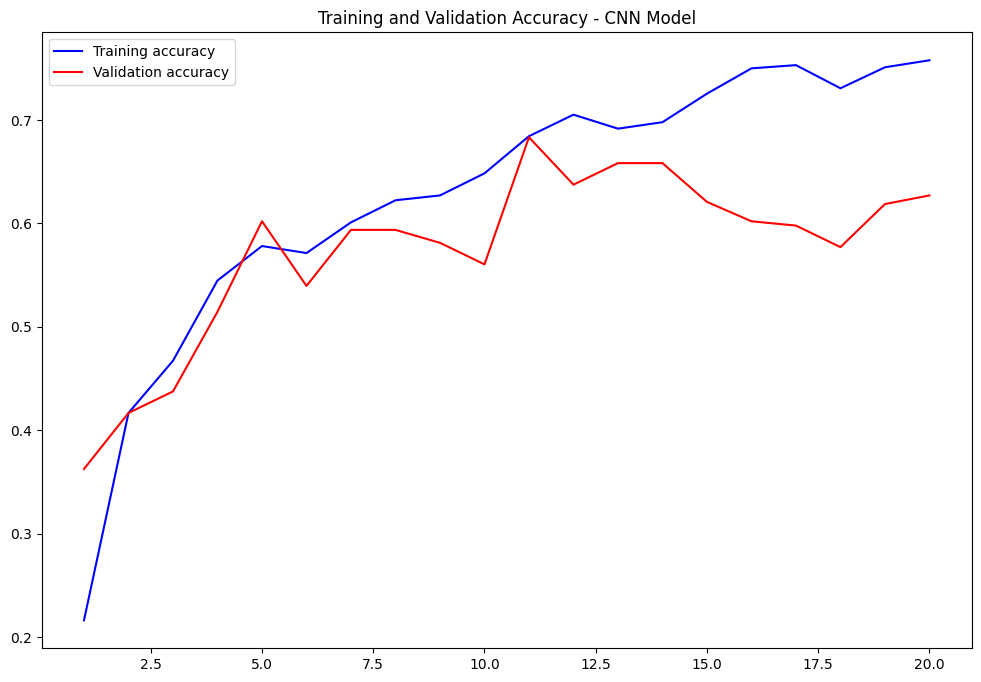

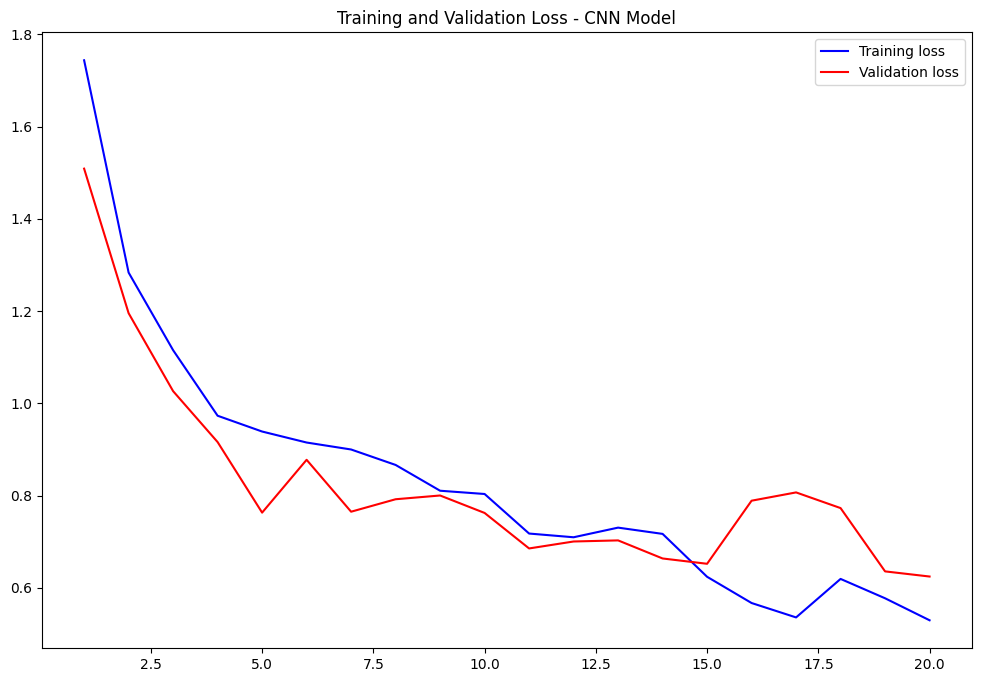

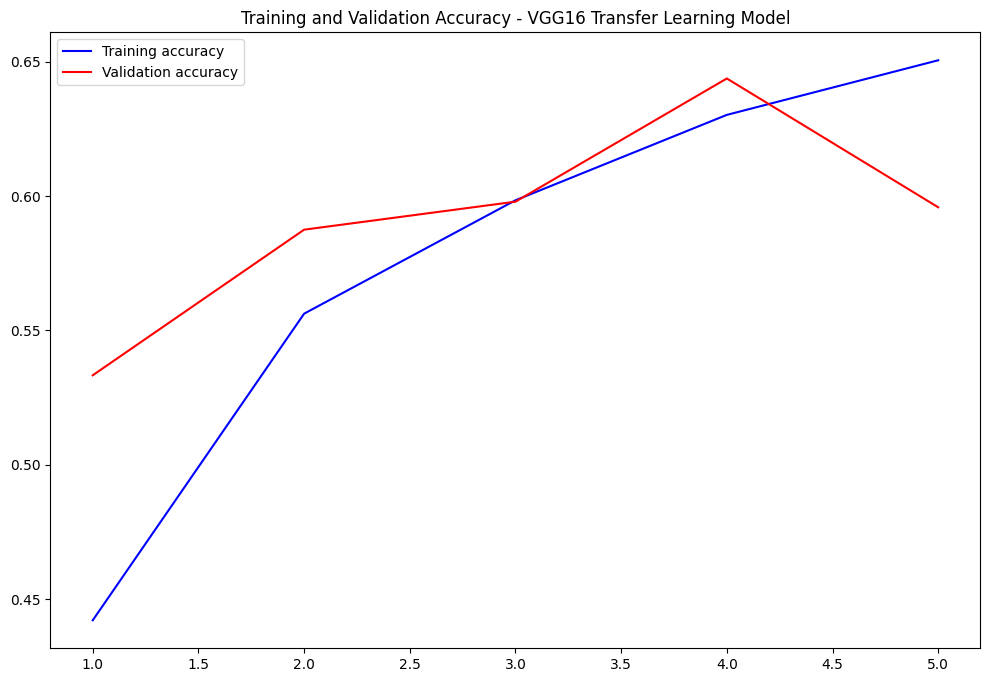

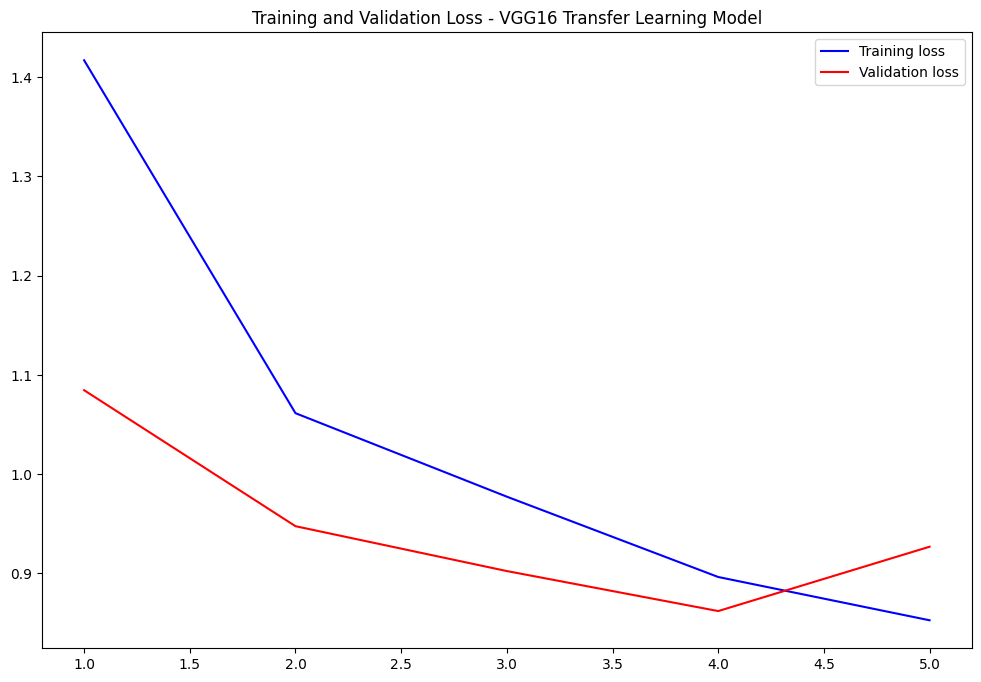

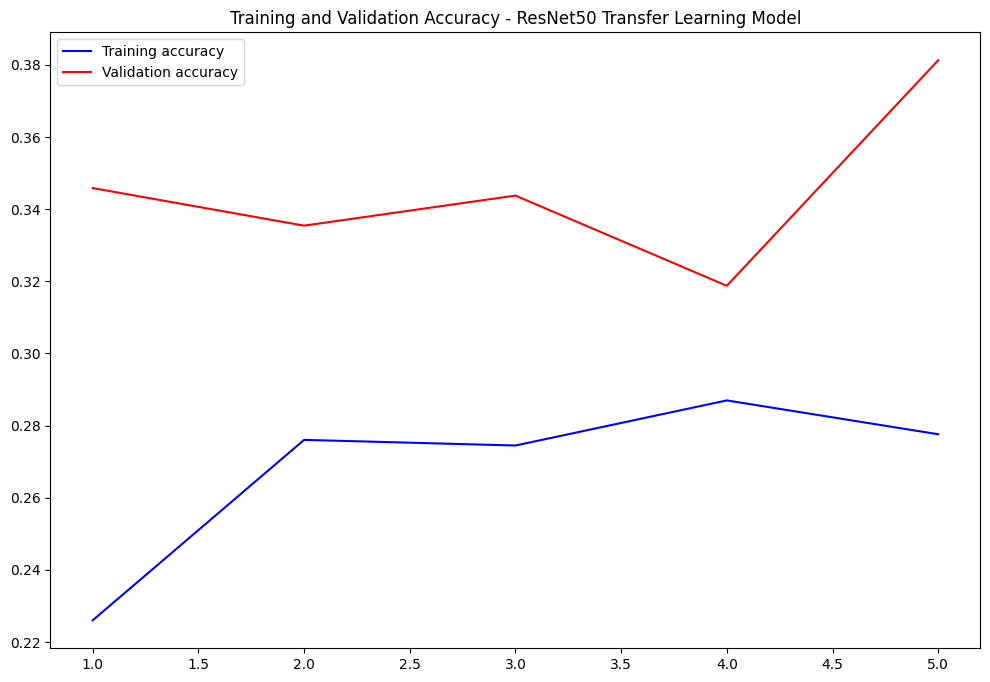

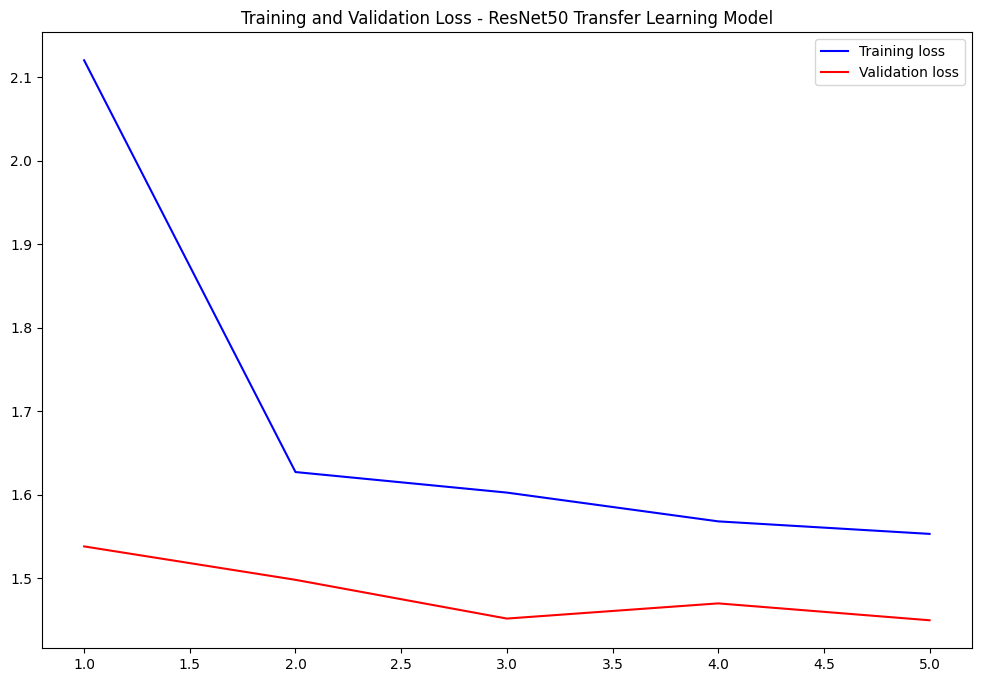

In [38]:
plot_training(cnn_history, "CNN Model")
plot_training(vgg16_history, "VGG16 Transfer Learning Model")
plot_training(resnet50_history, "ResNet50 Transfer Learning Model")